In [4]:
import breaching
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR10"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

C:\ProgramData\Anaconda3\envs\breaching\lib\site-packages\breaching\__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='cpu'), 'dtype': torch.float32}

In [6]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model='resnet18'

cfg.case.user.provide_labels = True

# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-3

In [8]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet18 loaded with 11,173,962 parameters and 9,620 buffers.
Overall this is a data ratio of     909:1 for target shape [4, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 4
        Data per local update step: 2
        Local learning rate: 0.001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type Optimiza

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 1 in model mode: eval.


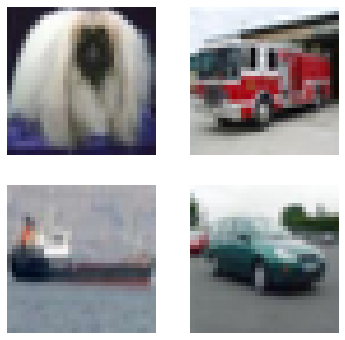

In [10]:
user.plot(true_user_data)

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

C:\ProgramData\Anaconda3\envs\breaching\lib\site-packages\torch\autocast_mode.py:156: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


| It: 1 | Rec. loss: 0.2123 |  Task loss: 2.5945 | T: 2.97s
| It: 1001 | Rec. loss: 0.0546 |  Task loss: 2.6641 | T: 6018.10s
Recovery interrupted manually in iteration 1066!
Optimal candidate solution with rec. loss 0.0506 selected.


In [12]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Abdul Haleem/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Files already downloaded and verified
METRICS: | MSE: 0.0210 | PSNR: 17.01 | FMSE: 1.6853e-02 | LPIPS: 0.09|
 R-PSNR: 17.01 | IIP-pixel: 100.00% | SSIM: 0.6750 | max R-PSNR: 19.06 | max SSIM: 0.7464 | Label Acc: 100.00%


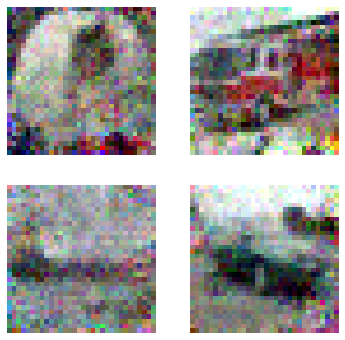

In [13]:
user.plot(reconstructed_user_data)